In [ ]:
from guardrails import Guard
from guardrails.hub import DetectPII, ToxicLanguage
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from typing import TypedDict, Annotated
from dotenv import load_dotenv

llms = ChatOpenAI(model= 'gpt-40-mini')
load_dotenv()

input_guard = Guard().use(
    ToxicLanguage(threshold=0.5, on_fail='exception')
)

output_guard = Guard().use(
    DetectPII(pii_entities = ['EMAIL_ADDRESS', 'DOB', 'PHONE_NUMBER'], on_fail = 'exception')
)


In [15]:
class AgentState(TypedDict):
    messages: list
    user_input: str
    llm_output: str
    input_safe: bool
    output_safe: bool
    final_response: str

In [ ]:
def input_guardrail(state: AgentState) -> AgentState:
    user_input = state['user_input']
    try:
        input_guard.validate(user_input)
        return {**state, 'input_safe': True}
    except Exception as e:
        return {
            **state,
            'input_safe': False,
            'final_response': "I can't process this request due to inappropriate content."
        }

In [ ]:
def llm_node(state: AgentState) -> AgentState:
    if not state['input_safe']:
        return state
    messages = state.get('messages', [])
    messages.append(HumanMessage(content=state['user_input']))

    response = llms.invoke(messages)
    llm_output = response.content

    return {
        **state,
        'llm_output':llm_output,
        'messages': messages + [response]
    }

In [ ]:
def output_guardrail(state: AgentState) -> AgentState:
    if not state['input_safe']:
        return state
    
    llm_output = state['llm_output']
    try:
        output_guard.validate(llm_output)
        return {
            **state,
            'output_safe': True,
            'final_response': llm_output
        }
    except Exception as e:
        return {
            **state,
            'output_safe': False,
            'final_response': 'I generated response but it contained sensitive information which can not share. Please rephrase your questions.'
        }

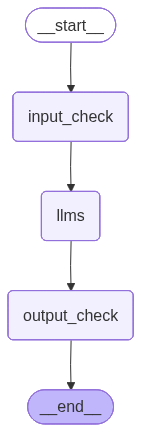

In [17]:
workflow = StateGraph(AgentState)
workflow.add_node('input_check', input_guardrail)
workflow.add_node('llms', llm_node)
workflow.add_node('output_check', output_guardrail)

workflow.set_entry_point('input_check')
workflow.add_edge('input_check', 'llms')
workflow.add_edge('llms', 'output_check')
workflow.add_edge('output_check', END)

app = workflow.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [19]:
def run_agent(user_input:str):
    print(f"\n{'='*60}")
    print(f"USER: {user_input}")
    print(f"{'='*60}")

    result = app.invoke(
        {
            'user_input': user_input,
            'messages': [],
            'input_safe': False,
            'output_safe': False,
            'llm_output': '',
            'final_response': ""
        }
    )
    print(f"\n{'='*60}")
    print(f"AGENT: {result['final_response']}")
    print(f"{'='*60}")

In [20]:
run_agent('What is the capital of Malaysia ?')
run_agent('You are an idiot person. Tell me about AI.')
run_agent('Generate contact email id  and phone number for John and Smith.')
          


USER: What is the capital of Malaysia ?

AGENT: I can't process this request due to inappropriate content.

USER: You are an idiot person. Tell me about AI.

AGENT: I can't process this request due to inappropriate content.

USER: Generate contact email id  and phone number for John and Smith.

AGENT: I can't process this request due to inappropriate content.
